In [13]:
# Package import
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

plt.ion()   # interactive mode

In [21]:
# Set the directories for the data and the CSV files that contain ids/labels

'''
Please note: 

Folders under the directory: dir_images (showed below) have been set up before data input, which means 
there should be two folders named as:
1. 'train' which is randomly selected from all train data (we randomly selected 80%) for training process
2. 'val' which is randomly selected from all train data (we randomly selected 20%) for validation

Every folder above should has saved images in correct subfolders which are labeled as 'Belize' and 'Honduras'.
'''

#dir_images  = './data'
dir_images  = './fishing_ground'

In [22]:
# CNN
# Data augmentation and input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100,150)),
        transforms.CenterCrop((70,150)),
        transforms.RandomHorizontalFlip(0.5),
        #transforms.Grayscale(1),
        torchvision.transforms.ColorJitter(brightness=0.1
                                           #, contrast=0.1, saturation=0.1, hue=0.1
                                          ),
        #transforms.RandomRotation(90),
        transforms.RandomCrop((50,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((100,150)),
        #transforms.CenterCrop((100,150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    }

data_dir = dir_images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[['Grunt Patch' 'Banco Tino']
 ['Harvest Cay' 'Banco Tino']]


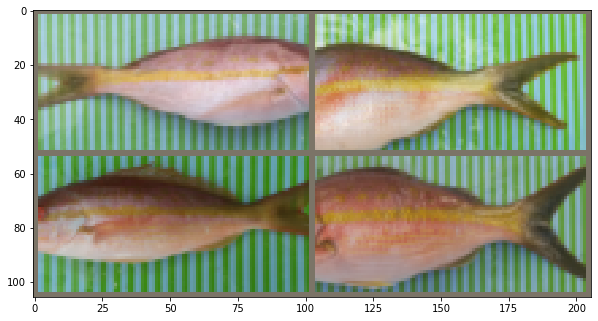

In [23]:
# Visualize Raw Data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title,loc='right')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=2)

plt.rcParams['figure.figsize']=10,10

imshow(out, title=print(np.asarray([class_names[x] for x in classes]).reshape(2,2)))

In [24]:
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [25]:
# Define train model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #predict = []
    #input_grad = []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                inputs = to_var(inputs, requires_grad=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    #if phase == 'train':
                        #outputs = outputs.logits
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        #input_grad.append(inputs.grad.data.cpu().numpy())
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            if (epoch + 1) % 10 ==0 or epoch == 0:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('-' * 10)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    torch.save(best_model_wts, "./model_rgb_fg.pt")
    
    return model

In [28]:
# Original train model is pretrained ResNet34
model_ft = models.resnet34(pretrained=True)
#model_ft = models.inception_v3(pretrained=True)

#Set up linear layer
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 5)

#model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

#O ptimizer Stochastic Gradient Decent
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, [50,75], gamma=0.1)

In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 6.9144 Acc: 0.2838

Epoch 0/99
----------
val Loss: 8.3383 Acc: 0.3204

Epoch 9/99
----------
train Loss: 1.2600 Acc: 0.4656

Epoch 9/99
----------
val Loss: 8.9320 Acc: 0.3883

Epoch 19/99
----------
train Loss: 1.1566 Acc: 0.4568

Epoch 19/99
----------
val Loss: 4.6693 Acc: 0.2330

Epoch 29/99
----------
train Loss: 1.0431 Acc: 0.5100

Epoch 29/99
----------
val Loss: 1.6227 Acc: 0.4272

Epoch 39/99
----------
train Loss: 0.9369 Acc: 0.5477

Epoch 39/99
----------
val Loss: 1.6566 Acc: 0.3107

Epoch 49/99
----------
train Loss: 0.8351 Acc: 0.6053

Epoch 49/99
----------
val Loss: 3.0365 Acc: 0.3592

Epoch 59/99
----------
train Loss: 0.6989 Acc: 0.6452

Epoch 59/99
----------
val Loss: 2.9383 Acc: 0.2718

Epoch 69/99
----------
train Loss: 0.6215 Acc: 0.7073

Epoch 69/99
----------
val Loss: 2.7464 Acc: 0.3107

Epoch 79/99
----------
train Loss: 0.5694 Acc: 0.7406

Epoch 79/99
----------
val Loss: 3.5755 Acc: 0.3010

Epoch 89/99
----------
train Los

In [42]:
model_ft_incep = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 4.3495 Acc: 0.5391

Epoch 0/99
----------
val Loss: 1.7494 Acc: 0.5954

Epoch 9/99
----------
train Loss: 0.6774 Acc: 0.6141

Epoch 9/99
----------
val Loss: 0.7984 Acc: 0.5954

Epoch 19/99
----------
train Loss: 0.5647 Acc: 0.7250

Epoch 19/99
----------
val Loss: 0.9843 Acc: 0.6641

Epoch 29/99
----------
train Loss: 0.4910 Acc: 0.7812

Epoch 29/99
----------
val Loss: 0.6435 Acc: 0.7176

Epoch 39/99
----------
train Loss: 0.3975 Acc: 0.8391

Epoch 39/99
----------
val Loss: 1.5260 Acc: 0.8550

Epoch 49/99
----------
train Loss: 0.2736 Acc: 0.9031

Epoch 49/99
----------
val Loss: 0.6242 Acc: 0.8931

Epoch 59/99
----------
train Loss: 0.2260 Acc: 0.9078

Epoch 59/99
----------
val Loss: 1.8878 Acc: 0.8473

Epoch 69/99
----------
train Loss: 0.2233 Acc: 0.9187

Epoch 69/99
----------
val Loss: 2.7840 Acc: 0.8397

Epoch 79/99
----------
train Loss: 0.1968 Acc: 0.9406

Epoch 79/99
----------
val Loss: 2.0963 Acc: 0.8473

Epoch 89/99
----------
train Los

In [17]:
for name, module in models.resnet34().named_children():
    print (name, module)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1